# Trader Behavior Analysis: From Raw Data to Initial Insights

### Objective
The goal is to ingest, clean, and explore the provided datasets to uncover the relationship between trader performance and market sentiment.

### Phases Covered
*  Data Ingestion and Validation
*  Data Cleaning and Preprocessing
*  Exploratory Data Analysis (EDA)

---
## Setup: Importing Necessary Libraries



In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional plot style
plt.style.use('seaborn-v0_8-whitegrid')

---
## Phase 2: Data Ingestion and Validation

 We load the two raw CSV files (`historical_data.csv` and `fear_greed_index.csv`) into pandas DataFrames. Immediately after loading, we perform a high-level inspection.



In [11]:
# Define file paths (ensure you have uploaded these files to Colab)
trader_data_path = 'historical_data.csv'
sentiment_data_path = 'fear_greed_index.csv'

# Load datasets
trader_df = pd.read_csv(trader_data_path)
sentiment_df = pd.read_csv(sentiment_data_path)

# --- Trader Data Inspection ---
print("--- Trader Data Overview ---")
print(trader_df.head())
print("\n")
trader_df.info()


# --- Sentiment Data Inspection ---
print("\n--- Sentiment Data Overview ---")
print(sentiment_df.head())
print("\n")
sentiment_df.info()

--- Trader Data Overview ---
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash  \
0      

/tmp/ipython-input-550412743.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trader_df = pd.read_csv(trader_data_path)


---
## Phase 3: Data Cleaning and Preprocessing
 This section focuses on transforming the raw data into a clean, unified format suitable for analysis. This involves converting data types, creating a common key for merging, and joining the two datasets.



In [12]:
# 1. Preprocess Trader Data: Convert 'time' from ms to datetime
trader_df['datetime'] = pd.to_datetime(trader_df['Timestamp'], unit='ms')
# 2. Preprocess Sentiment Data: Convert 'Date' and rename 'Classification'
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.rename(columns={'classification': 'sentiment'})

# 3. Create a common merge key (date only)
trader_df['date'] = trader_df['datetime'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])

# 4. Merge the two DataFrames
merged_df = pd.merge(
    trader_df,
    sentiment_df[['date', 'sentiment']],
    on='date',
    how='left'
)

# 5. Validate the merged DataFrame
print("--- Merged Data Overview ---")
merged_df.info()
print("\n")
print(f"Rows with missing sentiment after merge: {merged_df['sentiment'].isnull().sum()}")

--- Merged Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125831 entries, 0 to 125830
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Account           125831 non-null  object        
 1   Coin              125831 non-null  object        
 2   Execution Price   125831 non-null  float64       
 3   Size Tokens       125831 non-null  float64       
 4   Size USD          125831 non-null  float64       
 5   Side              125830 non-null  object        
 6   Timestamp IST     125830 non-null  object        
 7   Start Position    125830 non-null  float64       
 8   Direction         125830 non-null  object        
 9   Closed PnL        125830 non-null  float64       
 10  Transaction Hash  125830 non-null  object        
 11  Order ID          125830 non-null  float64       
 12  Crossed           125830 non-null  object        
 13  Fee               125830 non-n

---
## Exploratory Data Analysis (EDA)

 We perform initial analysis and create visualizations to explore the core questions of the assignment



--- Average PnL by Sentiment ---
sentiment
Greed            106.303330
Fear              68.840479
Extreme Greed     25.418772
Neutral           24.411566
Name: Closed PnL, dtype: float64


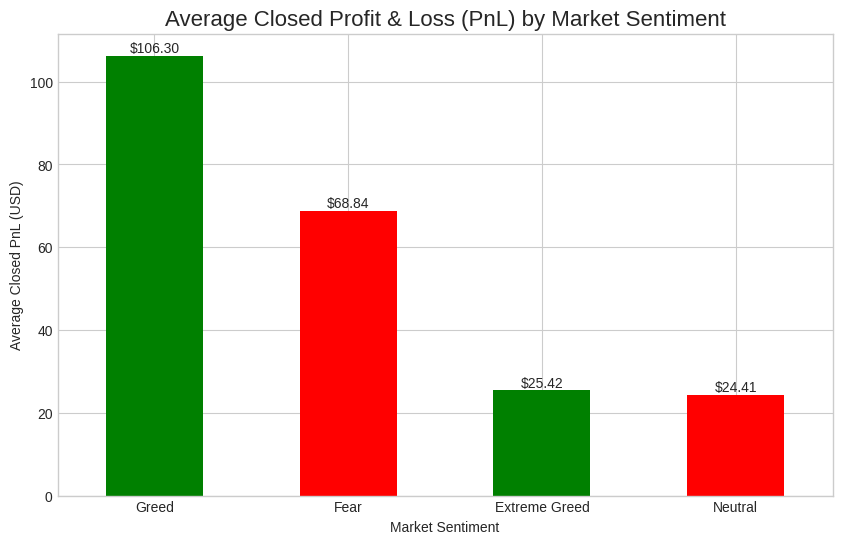

In [13]:
# For analysis, we must drop rows where sentiment is unknown
analysis_df = merged_df.dropna(subset=['sentiment', 'Closed PnL'])

# --- Analysis 1: Profitability vs. Sentiment ---
pnl_by_sentiment = analysis_df.groupby('sentiment')['Closed PnL'].mean().sort_values(ascending=False)

print("--- Average PnL by Sentiment ---")
print(pnl_by_sentiment)

fig, ax = plt.subplots(figsize=(10, 6))
pnl_by_sentiment.plot(kind='bar', ax=ax, color=['green', 'red'])
ax.set_title('Average Closed Profit & Loss (PnL) by Market Sentiment', fontsize=16)
ax.set_xlabel('Market Sentiment')
ax.set_ylabel('Average Closed PnL (USD)')
ax.tick_params(axis='x', rotation=0)
for container in ax.containers:
    ax.bar_label(container, fmt='$%.2f')
plt.show()




##Deeper Analysis

In [14]:
# --- 1. Calculate total PnL for each account ---
total_pnl_per_account = analysis_df.groupby('Account')['Closed PnL'].sum()

# --- 2. Find the performance thresholds for top 10% and bottom 10% ---
top_10_percentile = total_pnl_per_account.quantile(0.9)
bottom_10_percentile = total_pnl_per_account.quantile(0.1)

# --- 3. Get the list of top and bottom trader accounts ---
top_traders = total_pnl_per_account[total_pnl_per_account >= top_10_percentile].index
bottom_traders = total_pnl_per_account[total_pnl_per_account <= bottom_10_percentile].index

# --- 4. Create new DataFrames for each segment ---
top_trader_df = analysis_df[analysis_df['Account'].isin(top_traders)]
bottom_trader_df = analysis_df[analysis_df['Account'].isin(bottom_traders)]

print(f"Analysis will be performed on {len(top_traders)} top traders and {len(bottom_traders)} bottom traders.")

Analysis will be performed on 2 top traders and 2 bottom traders.



--- Average PnL by Sentiment (Top 10% Traders) ---
sentiment
Greed            394.664785
Fear             231.143230
Neutral           38.092624
Extreme Greed      0.847495
Name: Closed PnL, dtype: float64


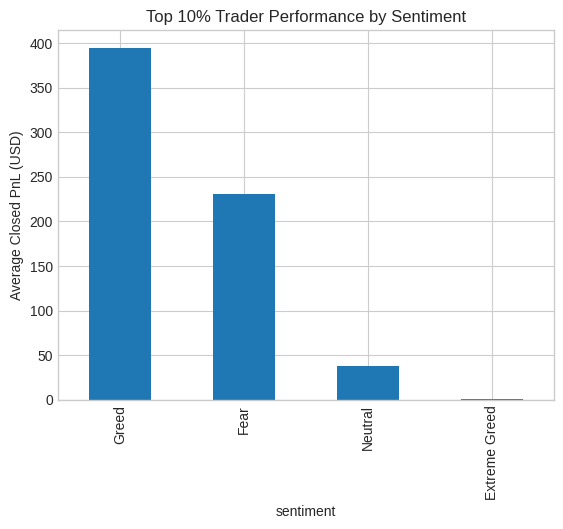

In [16]:
# --- Analyze the behavior of TOP traders ---
pnl_by_sentiment_top_traders = top_trader_df.groupby('sentiment')['Closed PnL'].mean().sort_values(ascending=False)

print("\n--- Average PnL by Sentiment (Top 10% Traders) ---")
print(pnl_by_sentiment_top_traders)

# Visualize the result
pnl_by_sentiment_top_traders.plot(kind='bar', title='Top 10% Trader Performance by Sentiment')
plt.ylabel('Average Closed PnL (USD)')
plt.show()


--- Average Trade Size (USD) by Sentiment (All Traders) ---
sentiment
Fear             5821.492883
Extreme Greed    5660.265764
Greed            4273.740384
Neutral          3030.247655
Name: Size USD, dtype: float64


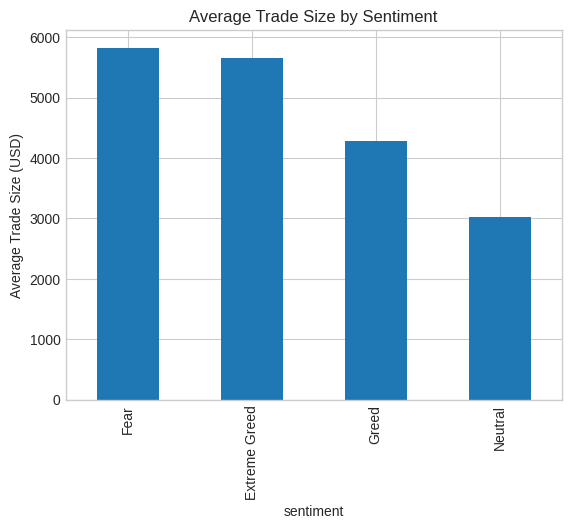

In [15]:
# Calculate the average trade size in USD by sentiment for all traders
size_by_sentiment = analysis_df.groupby('sentiment')['Size USD'].mean().sort_values(ascending=False)

print("\n--- Average Trade Size (USD) by Sentiment (All Traders) ---")
print(size_by_sentiment)

# Visualize the result
size_by_sentiment.plot(kind='bar', title='Average Trade Size by Sentiment')
plt.ylabel('Average Trade Size (USD)')
plt.show()